In [7]:
from sentinelhub import (
    SHConfig,
    BBox,
    CRS,
    bbox_to_dimensions,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
)

def get_images():
    
    # put here your sentinel hub credential (these expires on 18/11/2023)
    config = SHConfig()
    config.sh_client_id = "9a913fc0-cfef-4f57-9bb2-12d400e846b9"
    config.sh_client_secret = "TPZ8QMYA62RiUkFoanSF4F3Ai6hsoB9Le4tqNUbt"

    # customize this functions to specify the band you want to download
    evalscript = """
       //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

    # put here the coordinate of the image you want to download
    coordinates = (-80.27, 43.7125, -80.26, 43.704)

    # set the coordinate reference system
    crs = CRS.WGS84

    # set the desired resolution
    resolution = 0.4

    # set the time interval
    time_interval = ("2018-01-01", "2018-12-31")

    # set the source of the image
    data_collection = DataCollection.SENTINEL2_L1C

    # set the constant class for type of mosaicking order
    mosaicking_order = MosaickingOrder.LEAST_CC

    # update this value if you want to save the image
    save_data = True

    # set the folder where you want to dowload the image
    data_folder = './data/sentinel_images'

    # set the format of the image
    response_format = MimeType.TIFF

    
    bbox = BBox(bbox = coordinates, crs = crs)
    size = bbox_to_dimensions(bbox, resolution = resolution)
    request = SentinelHubRequest(
        config = config,
        bbox = bbox,
        size = size,
        evalscript = evalscript,
        data_folder = data_folder,
        input_data = [
            SentinelHubRequest.input_data(
                time_interval = time_interval,
                data_collection = data_collection,
                mosaicking_order = mosaicking_order
            )
        ],
        responses = [
            SentinelHubRequest.output_response(
                identifier = "default",
                response_format = response_format
            )
        ]
    )

    return request.get_data(save_data = save_data)

In [8]:
images = get_images()

for image in images:
    print(image.shape)



(2378, 1993, 13)


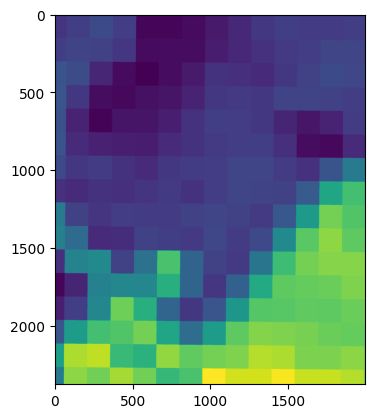

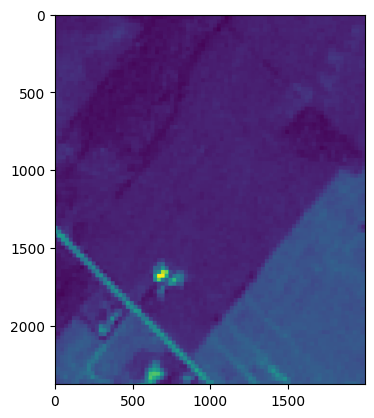

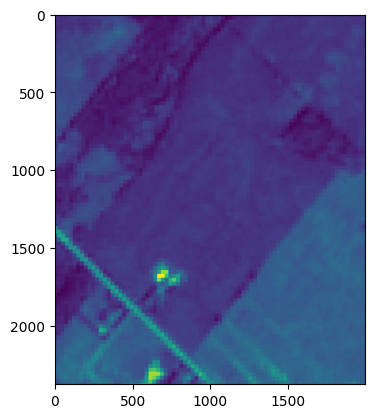

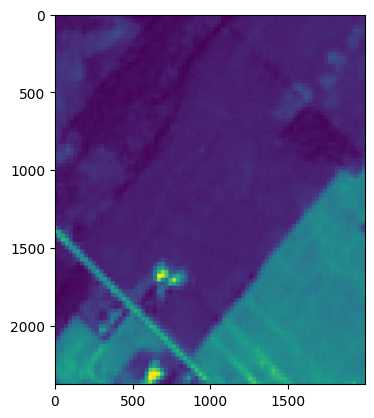

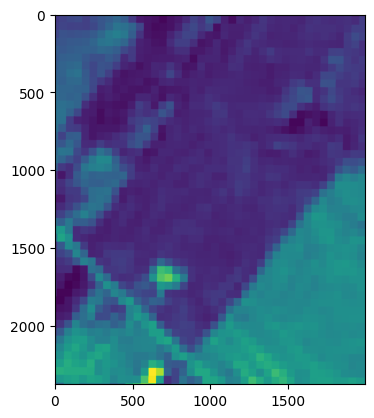

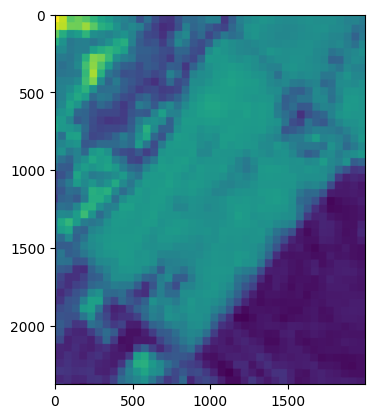

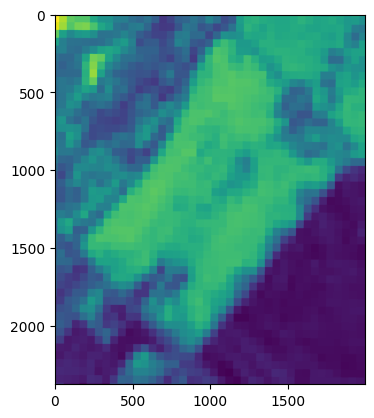

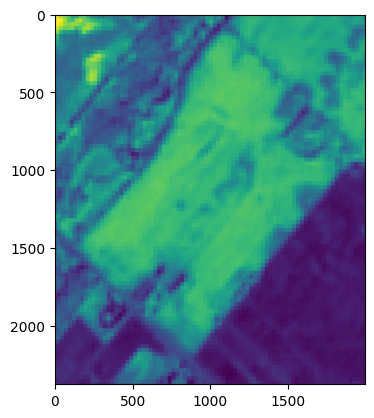

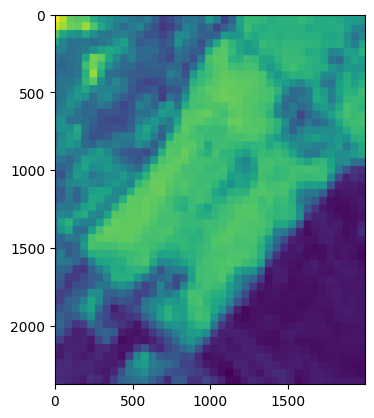

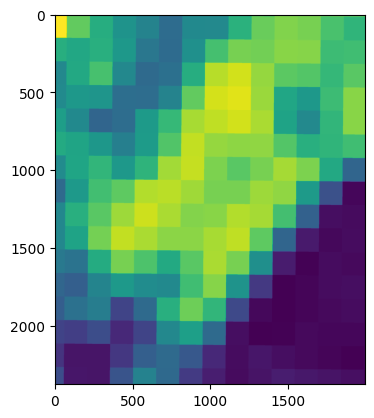

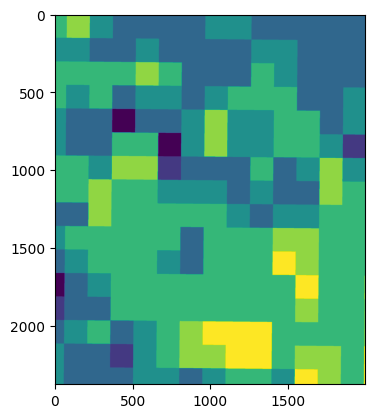

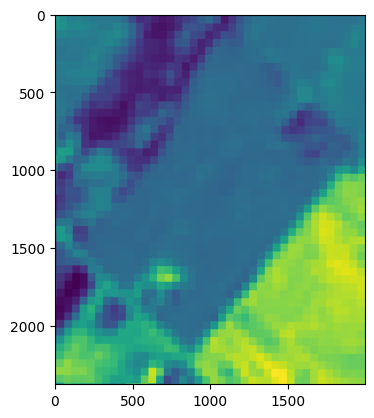

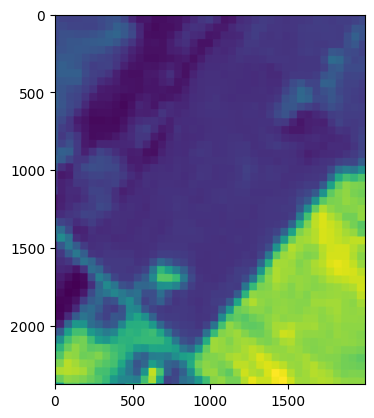

In [10]:
import rasterio 

from rasterio.plot import show

raster = rasterio.open("./data/sentinel_images/eca6374937ae5f499c4b13e5c83a08f6/response.tiff")

for i in range(1, raster.count + 1):
    img = raster.read(i)
    show(img)

raster.close()